Click [here](https://morihosseini.medium.com/mastering-time-series-forecasting-with-sktime-e8b96592cdb1) to access the associated Medium article.

# Setup

In [1]:
!pip install -q sktime matplotlib pandas

# Data

In [5]:
from sktime.datasets import load_airline

y = load_airline()
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

# Exploratory Time-Series Analysis

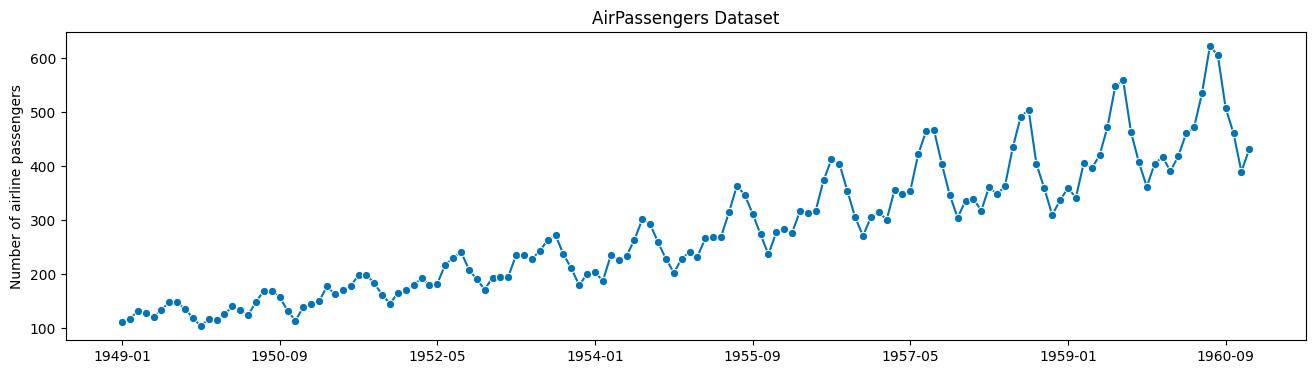

In [6]:
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

plot_series(y)
plt.title("AirPassengers Dataset")
plt.show()

## Detecting Seasonality

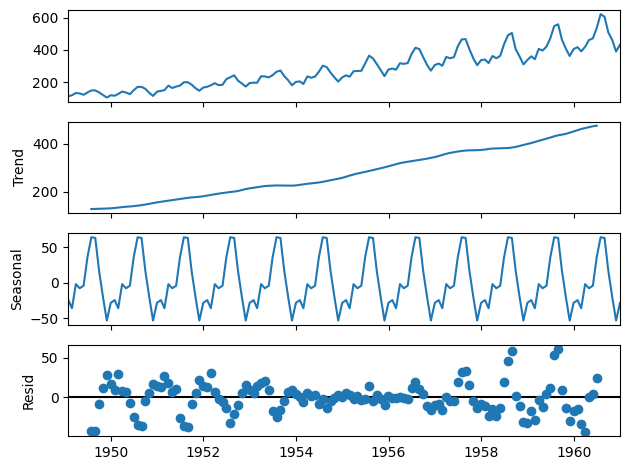

In [106]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert to pandas dataframe
y_df = pd.DataFrame(y.values, index=y.index.to_timestamp(freq="M"))

# Decompose the time series
decomposed = seasonal_decompose(y_df)

# Plot the decomposed time series
decomposed.plot();

## Auto Correlation Function and Partial Auto Correlation Function

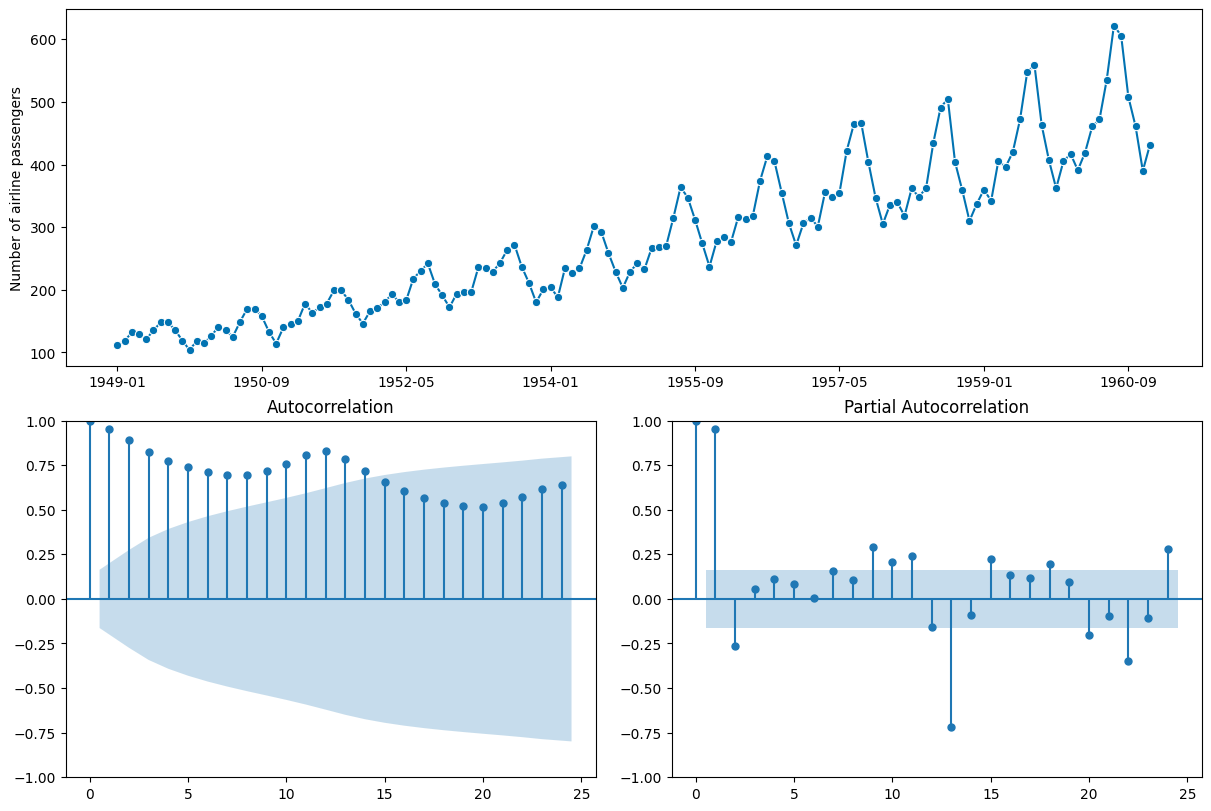

In [39]:
from sktime.utils.plotting import plot_correlations

plot_correlations(y);

## Statistical Tests for Stationarity

In [73]:
from sktime.param_est.stationarity import StationarityADF

sty_est = StationarityADF()
sty_est.fit(y)

print(f"ADF statistic: {sty_est.test_statistic_:.2f}")
print(f"p-value: {sty_est.pvalue_:.2f}")
print(f"The data is {'' if sty_est.stationary_ else 'not'} stationary.")

ADF statistic: 0.82
p-value: 0.99
The data is not stationary.


# Forecasting with Classical Methods

## Data Splitting

In [111]:
from sktime.forecasting.model_selection import temporal_train_test_split

# Horizon size = 36
y_train, y_test = temporal_train_test_split(y, test_size=36)

## Naive Forecaster

In [130]:
from sktime.forecasting.naive import NaiveForecaster

# Fit the forecaster
naive_forecaster = NaiveForecaster(strategy="last")
naive_forecaster.fit(y_train)

# Predict 36 steps ahead
naive_preds = forecaster.predict(fh=range(1, 37))
naive_preds.head()

1958-01    336.0
1958-02    336.0
1958-03    336.0
1958-04    336.0
1958-05    336.0
Freq: M, Name: Number of airline passengers, dtype: float64

## Exponential Smoothing

In [139]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Fit the forecaster
ets_forecaster = ExponentialSmoothing(
    trend="additive",
    seasonal="additive",
    sp=12,
)
ets_forecaster.fit(y_train)

# Predict 36 steps ahead
ets_preds = ets_forecaster.predict(fh=range(1, 37))
ets_preds.head()

1958-01    357.332353
1958-02    345.820169
1958-03    398.634554
1958-04    390.191995
1958-05    396.346394
Freq: M, Name: Number of airline passengers, dtype: float64

## ARIMA

In [160]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.sarimax import SARIMAX

# Fit the forecaster
arima_forecaster = ARIMA(seasonal_order=(1, 1, 1, 12))
arima_forecaster.fit(y_train)

# Predict 36 steps ahead
arima_preds = arima_forecaster.predict(fh=range(1, 37))
arima_preds.head()

1958-01    344.448891
1958-02    331.472840
1958-03    383.956004
1958-04    376.575094
1958-05    383.183513
Freq: M, Name: Number of airline passengers, dtype: float64

# Evaluating and Visualizing Forecasts

## Evaluating Forecasts

In [163]:
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error
)

mape_naive = mean_absolute_percentage_error(y_test, naive_preds)
mape_ets = mean_absolute_percentage_error(y_test, ets_preds)
mape_arima = mean_absolute_percentage_error(y_test, arima_preds)

print(f"MAPE Naive: {mape_naive:.2f}")
print(f"MAPE ETS: {mape_ets:.2f}")
print(f"MAPE ARIMA: {mape_arima:.2f}")

MAPE Naive: 0.20
MAPE ETS: 0.05
MAPE ARIMA: 0.04


## Visualizing Forecasts

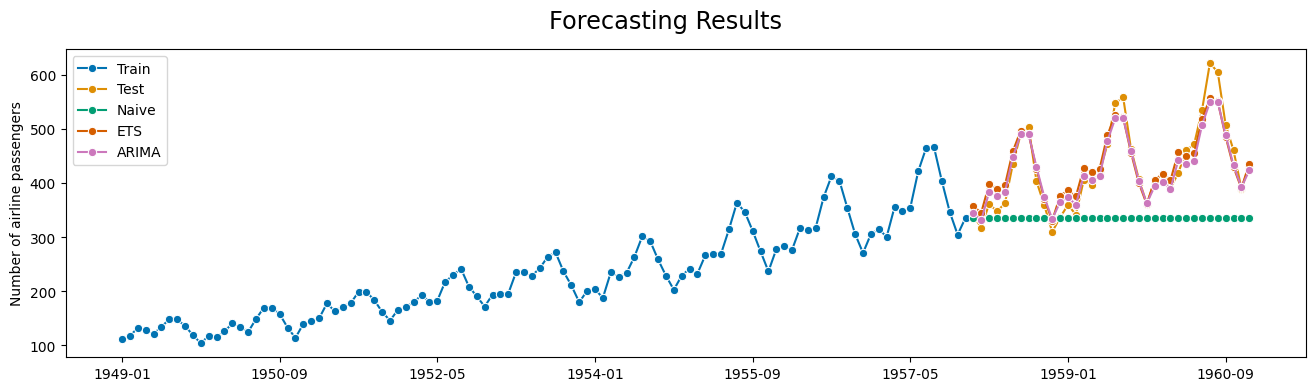

In [197]:
from sktime.utils.plotting import plot_series

plot_series(
    y_train,
    y_test,
    naive_preds,
    ets_preds,
    arima_preds,
    labels=["Train", "Test", "Naive", "ETS", "ARIMA"],
    title="Forecasting Results",
);

# Machine Learning Pipeline

In [217]:
from sktime.forecasting.compose import make_reduction
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

l_regressor = make_reduction(
    estimator=Pipeline([("regressor", LinearRegression())]),
    window_length=12,
)

rf_regressor = make_reduction(
    estimator=Pipeline(
        [
            ("regressor", RandomForestRegressor(random_state=42)),
        ]
    ),
    window_length=12,
)

# Fit the models
l_regressor.fit(y_train)
rf_regressor.fit(y_train)

# Predict 36 steps ahead
l_preds = l_regressor.predict(fh=range(1, 37))
rf_preds = rf_regressor.predict(fh=range(1, 37))

# Print the predictions
print("Linear Regression")
print(l_preds.head())

print("\n\nRandom Forest")
print(rf_preds.head())

Linear Regression
1958-01    352.755841
1958-02    345.708489
1958-03    388.697585
1958-04    388.083764
1958-05    409.020152
Freq: M, Name: Number of airline passengers, dtype: float64


Random Forest
1958-01    351.04
1958-02    349.16
1958-03    419.26
1958-04    433.74
1958-05    435.06
Freq: M, Name: Number of airline passengers, dtype: float64
